In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import learning_curve

from statsmodels.tsa.stattools import adfuller


In [3]:
# Collect and clean the data
raw_df = pd.read_csv('google-stock-dataset.csv')
raw_df

,Unnamed: 0,Date,Price,High,Low,Close,Volume,Adj Close
0,0,2013-04-15,19.67,19.94,19.44,19.57,98025876,19.57
1,1,2013-04-16,19.68,19.92,19.62,19.85,69610320,19.85
2,2,2013-04-17,19.69,19.79,19.47,19.58,81398520,19.58
3,3,2013-04-18,19.65,19.66,19.05,19.17,132767100,19.17
4,4,2013-04-19,19.25,20.11,19.18,20.02,231895872,20.02
...,...,...,...,...,...,...,...,...
2505,2505,2023-03-27,104.62,104.76,101.93,102.46,31120900,102.46
2506,2506,2023-03-28,102.44,102.45,99.74,101.03,32057900,101.03
2507,2507,2023-03-29,102.28,102.49,100.65,101.39,28779600,101.39
2508,2508,2023-03-30,100.91,101.16,99.78,100.89,33086200,100.89


In [4]:
raw_df = raw_df.drop(['Unnamed: 0', 'Adj Close'], axis=1)
raw_df.set_index("Date", inplace=True)
raw_df

,Price,High,Low,Close,Volume
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,98025876
2013-04-16,19.68,19.92,19.62,19.85,69610320
2013-04-17,19.69,19.79,19.47,19.58,81398520
2013-04-18,19.65,19.66,19.05,19.17,132767100
2013-04-19,19.25,20.11,19.18,20.02,231895872
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,31120900
2023-03-28,102.44,102.45,99.74,101.03,32057900
2023-03-29,102.28,102.49,100.65,101.39,28779600


In [5]:
# Check for empty value
raw_df.isna().sum()

Price     0
High      0
Low       0
Close     0
Volume    0
dtype: int64

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(-500.0, 0, '2021-04-08'),
  Text(0.0, 0, '2013-04-15'),
  Text(500.0, 0, '2015-04-09'),
  Text(1000.0, 0, '2017-04-03'),
  Text(1500.0, 0, '2019-03-29'),
  Text(2000.0, 0, '2021-03-24'),
  Text(2500.0, 0, '2023-03-20'),
  Text(3000.0, 0, '')])

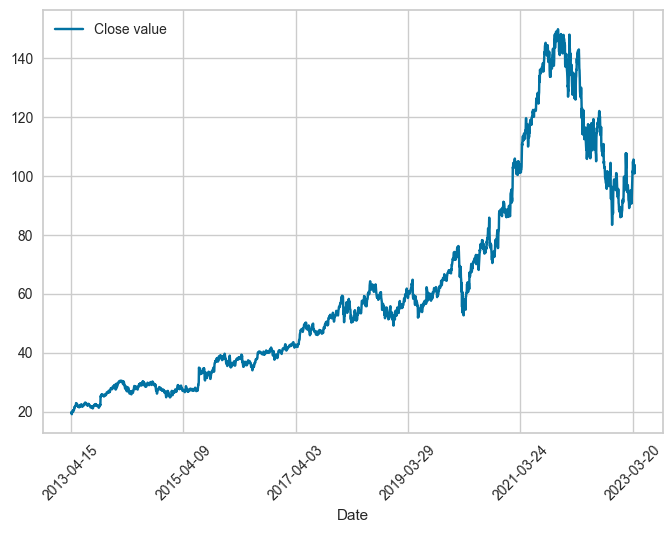

In [6]:
# Show the data visually
raw_df.plot(y="Close")
plt.legend(['Close value'])
plt.xticks(rotation=45)

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

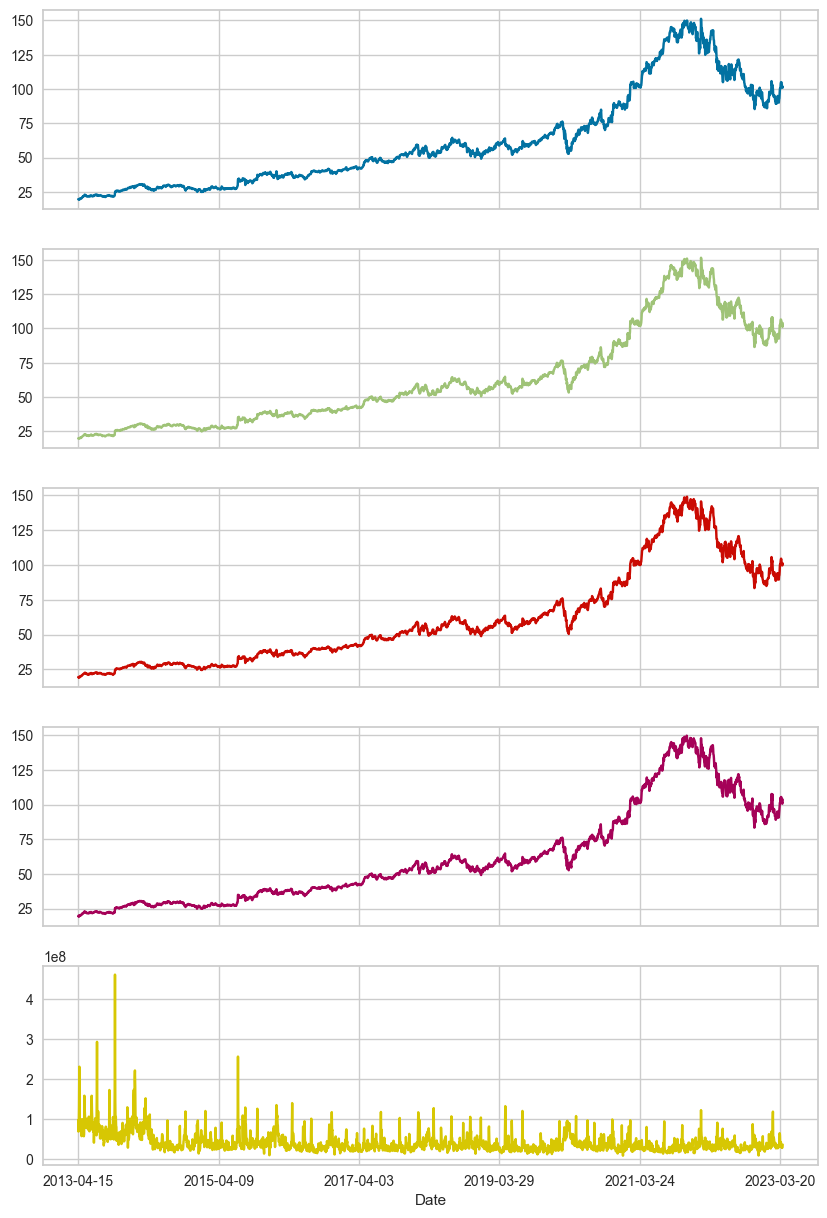

In [7]:
raw_df[['Price', 'High', 'Low', 'Close', 'Volume']].plot(subplots=True, figsize=(10, 15), xticks=None, kind='line', legend=None)

In [8]:
# Test for stationary using ADF (Augmented Dicket-Fuller Test)
def is_stationary(df):
    result = adfuller(df)
    test_statistic = result[0]
    p_value = result[1]
    ciritcal_values = result[4]
    
    for key, value in result[4].items():
        if test_statistic > value:
            return False
    return True

# Converting non-stationary to stationary
def convert_to_stationary(df):
    df_diff = df.diff().dropna()
    return df_diff

# Revert back to non stationary data
def revert_to_non_stationary(init, stat_df):
    df_rev_diff = np.r_[init, stat_df].cumsum()
    #df_square = np.square(df_rev_diff)
    return df_rev_diff

In [9]:
# Test for stationary data
for col in list(raw_df):
    print('Is stationary:', is_stationary(raw_df[col]))

Is stationary: False
Is stationary: False
Is stationary: False
Is stationary: False
Is stationary: True


In [10]:
# convert to stationary
stat_df = pd.DataFrame()
for col in list(raw_df):
    if not is_stationary(raw_df[col]):
        stat_df[col] = convert_to_stationary(raw_df[col])
        continue
    stat_df[col] = raw_df[col]

for col in list(stat_df):
    print('Is stationary:', is_stationary(stat_df[col]))

Is stationary: True
Is stationary: True
Is stationary: True
Is stationary: True
Is stationary: True


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

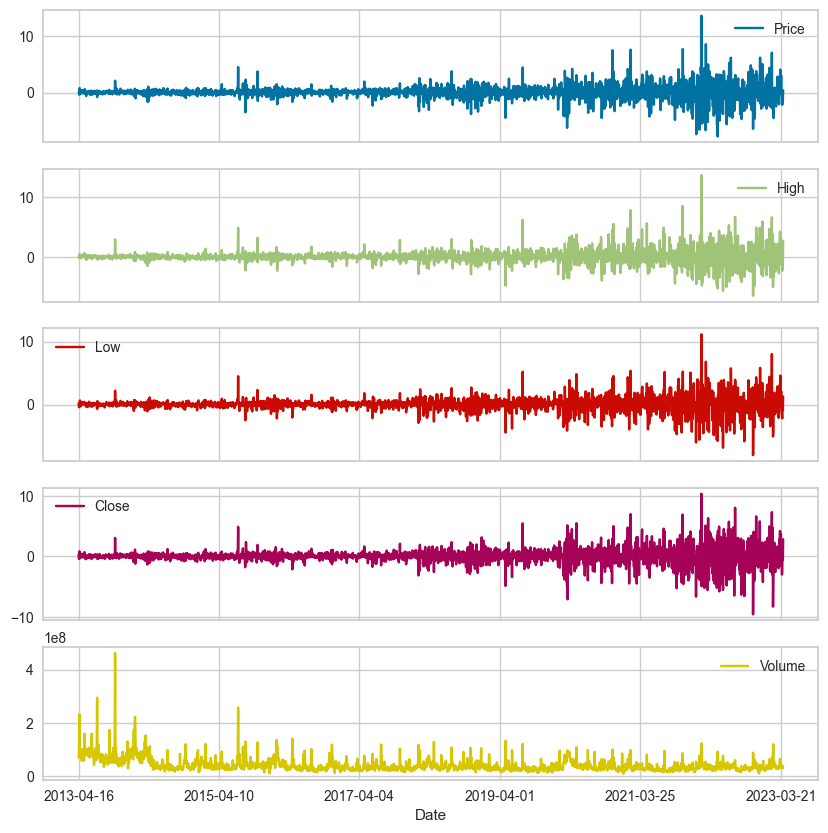

In [11]:
stat_df.plot(subplots=True, figsize=(10, 10))

<Axes: >

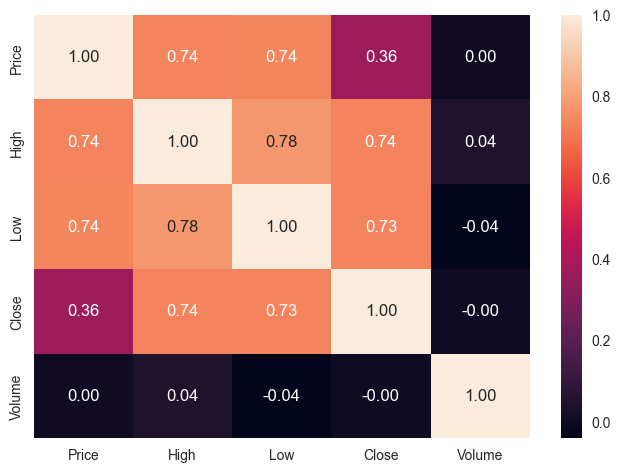

In [12]:
sns.heatmap(stat_df.corr(), robust=True, fmt='.2f', annot=True)

In [13]:
#### PREPROCESSING ####
stat_df = stat_df.dropna() # Drop missing data

# x_data = raw_df.iloc[:, raw_df.columns != 'Volume'].values # x_data.shape = (2510, 6)
x_data = stat_df.drop(['Close'], axis=1).values
y_data = stat_df['Close'].values # y_data.shape = (2510, )

# Scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)

# Divide into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0, shuffle=False)

y_data

array([ 0.28, -0.27, -0.41, ...,  0.36, -0.5 ,  2.84])

In [35]:
# Use the random grid to search for best hyperparameters (Using 3-folds cross validation). It takes too much time, so I commented it out.

grid_rf = {
'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=100)],  
'max_depth': [int(x) for x in np.linspace(10, 110, num=11)], 
'min_samples_split': [2, 5, 10], 
'min_samples_leaf': [1, 2, 4],  
'bootstrap': [True, False],
}

rscv = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)

# Fit the random search model
rscv_fit = rscv.fit(x_train, y_train)

best_parameters = rscv_fit.best_params_
print(best_parameters)

# ## RESULT (41m 54.7s) ###
# Fitting 3 folds for each of 200 candidates, totalling 600 fits
# {'n_estimators': 490, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 110, 'bootstrap': True}


Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'n_estimators': 236, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}


In [14]:
# Plot validation curve on paran 'n_estimators'
# viz = ValidationCurve(RandomForestRegressor(), param_name="n_estimators", param_range=np.arange(200, 2000, 100), cv=3, scoring="r2")
# viz.fit(x_scaled, y_data)
# viz.show()

In [14]:
model = RandomForestRegressor(n_estimators=236, min_samples_split=2, min_samples_leaf=2, max_depth=10, bootstrap=True)

In [15]:
# Train the model
model.fit(x_train, y_train) # Training the model

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=236)

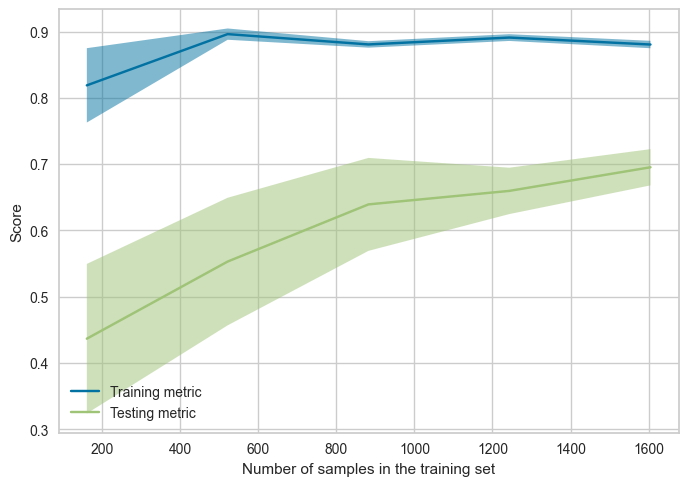

In [38]:
# Draw learning curve for training set
LearningCurveDisplay.from_estimator(model, x_train, y_train, score_type='both')

In [42]:
# Test the model
y_predict_train = model.predict(x_train)
y_predict = model.predict(x_test)
print('The model score is:', model.score(x_test, y_predict))

The model score is: 1.0


In [17]:
# Make the prediction
# x-axis
x_dates = []
predicted_dates = stat_df.index[x_train.shape[0]:]
restore_point = raw_df['Close'][predicted_dates[0]]
for d in predicted_dates:
    x_dates.append(mdates.date2num(dt.datetime.strptime(d, '%Y-%m-%d')))

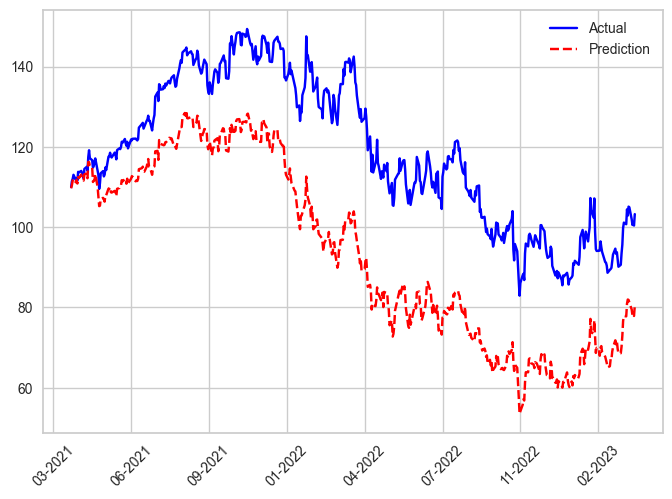

In [26]:
y_test_restored = revert_to_non_stationary(restore_point, y_test)[1:]
y_predict_restored = revert_to_non_stationary(restore_point, y_predict)[1:]

# Plot the test predictions
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)

plt.plot(x_dates, y_test_restored, color='blue')
plt.plot(x_dates, y_predict_restored, color='red', linestyle='--')
plt.gca().legend(('Actual', 'Prediction'))
plt.show()

In [43]:
# Performance evaludation
r2_score = sm.r2_score(y_test, y_predict)
print(f"(R^2) score: {round(r2_score, 4)* 100:.2f}%")

print(f'Train Score: {model.score(x_train, y_train) * 100:.2f}%')
print(f'Test Score: {model.score(x_test, y_test) * 100:.2f}%')

print("Testimg Mean Absolute Error:", round(sm.mean_absolute_error(y_test, y_predict), 4))
print("Training Mean Absolute Error:", round(sm.mean_absolute_error(y_train, y_predict_train), 4))

print("Testimg Mean Absolute Error:", round(sm.mean_squared_error(y_test, y_predict), 4))
print("Training Mean Absolute Error:", round(sm.mean_squared_error(y_train, y_predict_train), 4))


errors = abs(y_predict_restored - y_test_restored)
mape = 100 * (errors / y_test_restored)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

(R^2) score: 71.60%
Train Score: 87.54%
Test Score: 71.60%
Testimg Mean Absolute Error: 0.9182
Training Mean Absolute Error: 0.207
Accuracy: 78.52 %.


In [22]:
#### DOCUMENTATION ####
# https://stats.stackexchange.com/questions/235189/random-forest-regression-not-predicting-higher-than-training-data
# https://analyticsindiamag.com/how-to-make-a-time-series-stationary/
# https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/
# https://medium.com/@maryamuzakariya/project-predict-stock-prices-using-random-forest-regression-model-in-python-fbe4edf01664

# Video about stock prediction
# https://www.youtube.com/watch?v=KUFmCwCVXWs

# Why time series has to be stationary
# https://viblo.asia/p/tan-man-mot-chut-ve-time-series-data-p1-1VgZv6DpZAw

